In [ ]:
import warnings
warnings.filterwarnings('ignore')

<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Topic Modeling
## *Data Science Unit 4 Sprint 1 Lesson 4*
On Monday we talked about summarizing your documents using just token counts. Today, we're going to learn about a much more sophiscated approach - learning 'topics' from documents. Topics are a latent structure. They are not directly observable in the data, but we know they're there by reading them.

> **latent**: existing but not yet developed or manifest; hidden or concealed.

## Use Cases
Primary use case: what the hell are your documents about? Who might want to know that in industry - 
* Identifing common themes in customer reviews
* Discoverying the needle in a haystack 
* Monitoring communications (Email - State Department) 

## Learning Objectives
*At the end of the lesson you should be able to:*
* <a href="#p1">Part 1</a>: Describe how an LDA Model words
* <a href="#p2">Part 2</a>: Estimate a LDA Model with Gensim
* <a href="#p3">Part 3</a>: Interpret LDA results
* <a href="#p4">Part 4</a>: Select the appropriate number of topics

## Part 1: Latent Dirchilet Allocation (LDA) Models
<a id="#p1"></a>

LDA is a "generative probabilistic model". 

Let's play with a modoel available [here](https://lettier.com/projects/lda-topic-modeling/)

## Part 2: Estimating LDA Models with Gensim
<a id="#p1"></a>

### A Litterary Introduction: *Jane Austen V. Charlotte Bronte*
Despite being born nearly forty years apart, modern fans often pit Jane Austen & Charlotte Bronte against one another in a battle for litterary  supremacy. The battle centers around the topics of education for women, courting, and marriage. The authors' similiar backgrounds naturally draw comparisons, but the modern fascination is probably due to novelility of British women publishing novels during the early 19th century. 

Can we help close a litterary battle for supremacy and simply acknowledge that the authors addressed different topics and deserve to be acknowledged as excellent authors each in their own right?

We're going to apply Latent Dirichlet Allocation a machine learning alogrithm for topic modeling to each of the author's novels to compare the distribution of topics in their novels.

In [93]:
import numpy as np
import gensim
import os
import re
import pandas as pd

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore
from matplotlib import pyplot as plt

### Novel Data
I grabbed the novel data pre-split into a bunch of smaller chuncks

In [13]:
path = './data/austen-brontë-split'

### Text Preprocessing
**Challenge**: update the function `tokenize` with any technique you have learned so far this week. 

In [14]:
titles = [t[:-4] for t in os.listdir(path)]

In [15]:
STOPWORDS = set(STOPWORDS).union(set(['said', 'mr', 'mrs']))

def tokenize(text):
    return [token for token in simple_preprocess(text) if token not in STOPWORDS]

In [16]:
tokenize("Hello World! This a test of the tokenization method")

['hello', 'world', 'test', 'tokenization', 'method']

### Author DataFrame


In [17]:
df = pd.DataFrame(index=titles)

In [23]:
df.head(10)

,author,book,section
Austen_Sense0007,1,Sense,7
CBronte_Jane0184,0,Jane,184
CBronte_Jane0078,0,Jane,78
CBronte_Villette0057,0,Villette,57
CBronte_Professor0037,0,Professor,37
Austen_Pride0111,1,Pride,111
Austen_Sense0046,1,Sense,46
CBronte_Villette0110,0,Villette,110
Austen_Emma0118,1,Emma,118
CBronte_Jane0086,0,Jane,86


In [19]:
df['author'] = df.reset_index()['index'].apply(lambda x: x.split('_')[0]).tolist()
df['book'] = df.reset_index()['index'].apply(lambda x: x.split('_')[1][:-4]).tolist()
df['section'] = df.reset_index()['index'].apply(lambda x: x[-4:]).tolist()
df['section'] = df['section'].astype('int')

In [20]:
df['author'] = df['author'].map({'Austen':1, 'CBronte':0})

In [22]:
df.author.value_counts()

0    441
1    372
Name: author, dtype: int64

### Streaming Documents
Here we use a new pythonic thingy: the `yield` statement in our fucntion. This allows us to iterate over a bunch of documents without actually reading them into memory. You can see how we use this fucntion later on. 

In [24]:
def doc_stream(path):
    for f in os.listdir(path):
        with open(os.path.join(path,f)) as t:
            text = t.read().strip('\n')
            tokens = tokenize(str(text))
            yield tokens

### Gensim LDA Topic Modeling

In [102]:
ds = doc_stream(path)
dir(ds)

['__class__',
 '__del__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__name__',
 '__ne__',
 '__new__',
 '__next__',
 '__qualname__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'close',
 'gi_code',
 'gi_frame',
 'gi_running',
 'gi_yieldfrom',
 'send',
 'throw']

In [25]:
# A Dictionary Representation of all the words in our corpus
id2word = corpora.Dictionary(doc_stream(path))

In [100]:
type(id2word)

gensim.corpora.dictionary.Dictionary

In [26]:
id2word.doc2bow(tokenize('This is a sample message Darcy England England england'))

[(404, 3), (1456, 1), (2750, 1), (6863, 1)]

In [27]:
id2word.token2id['england']

404

In [130]:
# Let's remove extreme values from the dataset
id2word.filter_extremes(no_below=10, no_above=0.75)

In [48]:
# a bag of words(bow) representation of our corpus
# Note: we haven't actually read any text into memory here
corpus = [id2word.doc2bow(text) for text in doc_stream(path)]

In [139]:
len(corpus[5])#[0][0]

273

In [49]:
lda = LdaMulticore(corpus=corpus,
                   id2word=id2word,
                   random_state=723812,
                   num_topics = 15,
                   passes=10,
                   workers=4
                  )

In [ ]:
dir(lda)

In [56]:
lda.print_topics()

[(0,
  '0.019*"elinor" + 0.013*"marianne" + 0.009*"edward" + 0.008*"dashwood" + 0.008*"sister" + 0.007*"mother" + 0.006*"know" + 0.006*"lucy" + 0.006*"think" + 0.006*"willoughby"'),
 (1,
  '0.014*"marianne" + 0.009*"elinor" + 0.006*"jennings" + 0.006*"sister" + 0.005*"moment" + 0.005*"saw" + 0.005*"place" + 0.005*"elizabeth" + 0.005*"soon" + 0.004*"room"'),
 (2,
  '0.009*"like" + 0.008*"shall" + 0.007*"adele" + 0.006*"ll" + 0.006*"sir" + 0.005*"day" + 0.005*"crimsworth" + 0.005*"rochester" + 0.005*"thought" + 0.004*"till"'),
 (3,
  '0.007*"know" + 0.006*"miss" + 0.006*"old" + 0.005*"monsieur" + 0.005*"man" + 0.005*"think" + 0.005*"like" + 0.005*"mother" + 0.004*"thought" + 0.004*"felt"'),
 (4,
  '0.012*"marianne" + 0.011*"elinor" + 0.009*"bessie" + 0.007*"sister" + 0.007*"room" + 0.006*"jennings" + 0.006*"day" + 0.005*"soon" + 0.005*"come" + 0.004*"miss"'),
 (5,
  '0.008*"life" + 0.007*"like" + 0.007*"long" + 0.006*"day" + 0.005*"monsieur" + 0.005*"address" + 0.005*"shire" + 0.004*"tho

In [50]:
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.print_topics()]

In [ ]:
words

In [76]:
topics = [' '.join(t[0:5]) for t in words]

In [77]:
topics

['elinor marianne edward dashwood sister',
 'marianne elinor jennings sister moment',
 'like shall adele ll sir',
 'know miss old monsieur man',
 'marianne elinor bessie sister room',
 'life like long day monsieur',
 'harriet emma elton martin miss',
 'thought like frances life know',
 'like room thought day eyes',
 'miss emma elizabeth jane think',
 'sir jane rochester love shall',
 'mdlle henri like thought monsieur',
 'lady sir john house young',
 'madame paul beck like monsieur',
 'like st house john come']

## Part 3: Interpret LDA Results
<a id="#p3"></a>

### Topic Distance Visualization

In [78]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

In [79]:
pyLDAvis.gensim.prepare(lda, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.103541  0.044738       1        1  29.530409
8     -0.064265 -0.008514       2        1  25.665192
0      0.142161  0.009968       3        1   9.920813
7     -0.058030  0.012318       4        1   6.913198
14    -0.059511  0.002907       5        1   6.739651
13    -0.105114 -0.007403       6        1   6.020559
10    -0.024913  0.069320       7        1   4.151514
4      0.074338 -0.019177       8        1   3.194840
12     0.123582 -0.028488       9        1   2.259156
11    -0.080440 -0.005504      10        1   1.796941
6      0.030933  0.094835      11        1   1.498930
1      0.088346 -0.106648      12        1   0.777932
3     -0.006781  0.045751      13        1   0.701634
2     -0.096894  0.014299      14        1   0.565215
5     -0.066955 -0.118404      15        1   0.264019, topic_info=     Category         Freq           Term        Total  loglift  logprob
term                                                                    
1546  Default   853.000000           emma   853.000000  30.0000  30.0000
1566  Default   503.000000        harriet   503.000000  29.0000  29.0000
77    Default   677.000000         elinor   677.000000  28.0000  28.0000
394   Default  1337.000000           like  1337.000000  27.0000  27.0000
381   Default   947.000000           jane   947.000000  26.0000  26.0000
151   Default   550.000000       marianne   550.000000  25.0000  25.0000
596   Default  1536.000000           miss  1536.000000  24.0000  24.0000
228   Default   603.000000            sir   603.000000  23.0000  23.0000
1140  Default   640.000000      elizabeth   640.000000  22.0000  22.0000
3707  Default   379.000000          elton   379.000000  21.0000  21.0000
54    Default  1056.000000            day  1056.000000  20.0000  20.0000
883   Default  1147.000000        thought  1147.000000  19.0000  19.0000
805   Default   421.000000         madame   421.000000  18.0000  18.0000
225   Default   932.000000          shall   932.000000  17.0000  17.0000
996   Default   615.000000           lady   615.000000  16.0000  16.0000
397   Default   942.000000           long   942.000000  15.0000  15.0000
136   Default  1445.000000           know  1445.000000  14.0000  14.0000
1233  Default   582.000000         sister   582.000000  13.0000  13.0000
255   Default  1322.000000          think  1322.000000  12.0000  12.0000
123   Default   750.000000          house   750.000000  11.0000  11.0000
440   Default   776.000000            saw   776.000000  10.0000  10.0000
146   Default   585.000000           life   585.000000   9.0000   9.0000
436   Default   365.000000      rochester   365.000000   8.0000   8.0000
2568  Default   385.000000      knightley   385.000000   7.0000   7.0000
150   Default   913.000000            man   913.000000   6.0000   6.0000
2445  Default   309.000000      woodhouse   309.000000   5.0000   5.0000
212   Default   886.000000           room   886.000000   4.0000   4.0000
597   Default   670.000000         mother   670.000000   3.0000   3.0000
236   Default   926.000000           soon   926.000000   2.0000   2.0000
254   Default   790.000000          thing   790.000000   1.0000   1.0000
...       ...          ...            ...          ...      ...      ...
146   Topic15     5.720812           life   585.041870   1.3093  -4.8854
839   Topic15     1.437520         repose    38.797558   2.6415  -6.2665
1016  Topic15     3.647271       monsieur   280.421844   1.5946  -5.3355
1871  Topic15     1.437549        despair    40.673161   2.5943  -6.2665
1709  Topic15     2.138753     thornfield    98.668449   2.1054  -5.8692
1012  Topic15     2.156903          mdlle   108.681221   2.0172  -5.8608
397   Topic15     4.979172           long   942.327026   0.6938  -5.0242
565   Topic15     2.851754          hands   233.708176   1.5308  -5.5815
394   Topic15     5.067111           like  133

### Overall Model / Documents

In [80]:
lda[corpus[0]]

[(0, 0.207369), (4, 0.60605294), (12, 0.1844029)]

In [81]:
distro = [lda[d] for d in corpus]

In [82]:
distro[0]

[(0, 0.20739292), (4, 0.6060076), (12, 0.18442437)]

In [83]:
def update(doc):
        d_dist = {k:0 for k in range(0,15)}
        for t in doc:
            d_dist[t[0]] = t[1]
        return d_dist
    
new_distro = [update(d) for d in distro]

In [84]:
d_dist = {k:0 for k in range(0,15)}
d_dist

{0: 0,
 1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 0}

In [85]:
df = pd.DataFrame.from_records(new_distro, index=titles)
df.columns = topics

In [86]:
df['author'] = df.reset_index()['index'].apply(lambda x: x.split('_')[0]).tolist()
df['book'] = df.reset_index()['index'].apply(lambda x: x.split('_')[1][:-4]).tolist()
df['section'] = df.reset_index()['index'].apply(lambda x: x[-4:]).tolist()
df['section'] = df['section'].astype('int')
#df['author'] = df['author'].map({'Austen':1, 'CBronte':0})

In [87]:
df.head()

,elinor marianne edward dashwood sister,marianne elinor jennings sister moment,like shall adele ll sir,know miss old monsieur man,marianne elinor bessie sister room,life like long day monsieur,harriet emma elton martin miss,thought like frances life know,like room thought day eyes,miss emma elizabeth jane think,sir jane rochester love shall,mdlle henri like thought monsieur,lady sir john house young,madame paul beck like monsieur,like st house john come,author,book,section
Austen_Sense0007,0.207393,0.0,0.0,0.0,0.606008,0.0,0.0,0.00000,0.000000,0.000000,0.00000,0.000000,0.184424,0.000000,0.000000,Austen,Sense,7
CBronte_Jane0184,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.69794,0.000000,0.000000,0.000000,0.299141,CBronte,Jane,184
CBronte_Jane0078,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.997229,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,CBronte,Jane,78
CBronte_Villette0057,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.653882,0.000000,0.00000,0.000000,0.000000,0.319017,0.025054,CBronte,Villette,57
CBronte_Professor0037,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.09984,0.014957,0.102596,0.00000,0.337192,0.000000,0.000000,0.443503,CBronte,Professor,37


In [88]:
df.groupby('author').mean()

,elinor marianne edward dashwood sister,marianne elinor jennings sister moment,like shall adele ll sir,know miss old monsieur man,marianne elinor bessie sister room,life like long day monsieur,harriet emma elton martin miss,thought like frances life know,like room thought day eyes,miss emma elizabeth jane think,sir jane rochester love shall,mdlle henri like thought monsieur,lady sir john house young,madame paul beck like monsieur,like st house john come,section
author,,,,,,,,,,,,,,,,
Austen,0.206944,0.013816,0.000000,0.001684,0.048711,0.000000,0.029767,0.002553,0.009164,0.637057,0.001923,0.000894,0.042746,0.000037,0.001976,62.403226
CBronte,0.006518,0.001465,0.010986,0.012793,0.016168,0.004523,0.001905,0.124953,0.452579,0.014507,0.081807,0.032479,0.003779,0.104903,0.127774,80.464853


## Part 4: Selecting the Number of Topics
<a id="#p4"></a>

In [89]:
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, path, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    path : path to input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        stream = doc_stream(path)
        model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=id2word, workers=4)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=stream, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [96]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        path=path, 
                                                        start=4, 
                                                        limit=41, 
                                                        step=3)

In [152]:
model_list

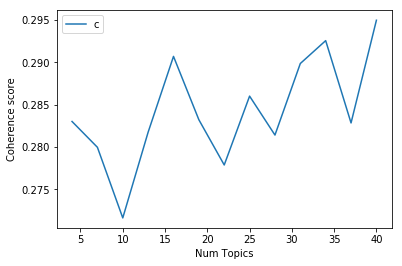

In [98]:
# Show graph
limit=41; start=4; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [99]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 4  has Coherence Value of 0.283
Num Topics = 7  has Coherence Value of 0.28
Num Topics = 10  has Coherence Value of 0.2716
Num Topics = 13  has Coherence Value of 0.2817
Num Topics = 16  has Coherence Value of 0.2907
Num Topics = 19  has Coherence Value of 0.2832
Num Topics = 22  has Coherence Value of 0.2779
Num Topics = 25  has Coherence Value of 0.286
Num Topics = 28  has Coherence Value of 0.2814
Num Topics = 31  has Coherence Value of 0.2899
Num Topics = 34  has Coherence Value of 0.2926
Num Topics = 37  has Coherence Value of 0.2828
Num Topics = 40  has Coherence Value of 0.295


## Additional Resources
## Resources

* [Gensim](https://radimrehurek.com/gensim/): Python package for topic modeling, nlp, word vectorization, and few other things. Well maintained and well documented.
* [Topic Modeling with Gensim](http://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#11createthedictionaryandcorpusneededfortopicmodeling): A kind of cookbook for LDA with gensim. Excellent overview, but the you need to be aware of missing import statements and assumed prior knowledge.
* [Chinese Restuarant Process](https://en.wikipedia.org/wiki/Chinese_restaurant_process): That really obscure stats thing I mentioned... 
* [PyLDAvis](https://github.com/bmabey/pyLDAvis): Library for visualizing the topic model and performing some exploratory work. Works well. Has a direct parrell implementation in R as well. 
* [Rare Technologies](https://rare-technologies.com/): The people that made & maintain gensim and a few other libraries.
* [Jane Austen v. Charlotte Bronte](https://www.literaryladiesguide.com/literary-musings/jane-austen-charlotte-bronte-different-alike/)

## Test if one author focuses more on women or men

- use spacyfor text preprocessing
- extract the named entities from the doc
- create a unique list of names from the authors
- label the names with genders (US census name list, or by hand)
- customize your processing to replace proper name w/ gender from prev steps lookup table
- follow the rest of the LDA flow


In [144]:
import spacy
nlp = spacy.load("en_core_web_lg")

test = 'Ned asked a question about England today'
doc = nlp(test)

for token in doc:
    print(token.text, token.lemma_, token.pos_)

Ned Ned PROPN
asked ask VERB
a a DET
question question NOUN
about about ADP
England England PROPN
today today NOUN


In [145]:
for ent in doc.ents:
    print(ent.text, ent.label_)

Ned PERSON
England GPE
today DATE


In [148]:
def text_doc_stream(path):
    for f in os.listdir(path):
        with open(os.path.join(path,f)) as t:
            text = t.read().strip('\n')
            yield text
            
def get_people(docstream):
    ppl = []
    for d in docstream:
        doc = nlp(d)
        for ent in doc.ents:
            if ent.label_== 'PERSON':
                ppl.append(ent.text)
    return set(ppl)

In [149]:
people = get_people(text_doc_stream(path))

In [151]:
people_s = pd.Series(list(people))
people_s.head(50)

0                      Cole\n
1                Arthur!--How
2                       Waddy
3                   M. Lucien
4                     Zoraide
5                  Willoughby
6                  Harriet.\n
7                 Mary Rivers
8      n'est-ce\npas que cela
9                       Pratt
10                     Pamela
11                     Madame
12    fait\ntout l'effet d'un
13                    Louison
14         Emma Woodhouse-ing
15           Bitternutt Lodge
16                  Alnaschar
17                   Nicholls
18                  Rue Crecy
19                     Watson
20               Paul de Kock
21                      I. He
22              Frances Evans
23                  Appliquee
24                   Caligula
25             Justine\nMarie
26                       Bird
27                      Comme
28                      Adela
29                      Bella
30                  mind.--It
31                Willoughbys
32             Frances Evans'
33        